# Algoritmo 1 (Fudidasso)

In [1]:
%matplotlib inline

import numpy as np
import numpy.random as rng
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import multivariate_normal, invgamma
from scipy.stats import norm, uniform
from statsmodels.tsa.statespace.tools import is_invertible
from statsmodels.graphics.tsaplots import plot_acf
from IPython.display import clear_output

sns.set()

In [2]:
# Importando a série do Ibovespa
df = pd.read_csv('ibov.csv', sep=';', encoding='utf-8-sig', index_col=0)

# data para datetime
df['Data/Hora'] = pd.to_datetime(df['Data/Hora'], format='%d/%m/%Y')

# df.set_index('Data/Hora')['Cotação'].plot(kind='line', figsize=(16,4), 
#                                           title='Ibovespa 16/11/2006 - 14/11/2019')

In [3]:
ibov = df.set_index('Data/Hora')['Cotação'].sort_index(ascending=True)
log_ibov = np.log(ibov).diff()[1:] 

# Plot the series to see what it looks like
# fig, ax = plt.subplots(figsize=(13, 3), dpi=300)
# ax.plot(log_ibov, label=r'$\Delta \log Ibov$')
# ax.set_title(r'$\Delta \log Ibov$')
# ax.yaxis.grid(b=True);

In [4]:
# y = log-retorno corrigido pela média
# y = 100*(log_ibov - np.cumsum(log_ibov)/np.array(range(1,len(ibov))))[:1000]
y = 100*(log_ibov - np.mean(log_ibov))[:1000]

<br>

## Algoritmo base: Gibbs-Sampler

No paper original (Kim, Shephard e Chib - 1998), foram executadas 1.000.000 iterações, com um *burn-in* de 50.000 observações.

### Amostrando de ht | theta, y, h\t

### Amostrando de $\sigma^2_n \mid y, h,\phi, \mu$

https://cran.r-project.org/web/packages/stochvol/vignettes/article.pdf

http://hedibert.org/wp-content/uploads/2013/12/sv-ar1-routines.R.txt

http://hedibert.org/wp-content/uploads/2013/12/sv-ar1.R.txt

http://hedibert.org/monte-carlo-methods-and-stochastic-volatility/

https://cran.r-project.org/web/packages/stochvol/stochvol.pdf

In [5]:
def draw_posterior_mu(T, states, phi, sigma2):
    sigma2_mu = sigma2 / ((T - 1) * (1 - phi)**2 + (1 - phi**2))

    tmp1 = ((1 - phi**2) / sigma2) * states[0]
    tmp = ((1 - phi) / sigma2) * np.sum(states[1:] - phi * states[:-1])
    mu_hat = sigma2_mu * (tmp1 + tmp)

    return norm.rvs(loc=mu_hat, scale=sigma2_mu**0.5)

In [6]:
def g(phi, states, mu, sigma2, prior_params=(20, 1.5)):
    phi_1, phi_2 = prior_params

    # Prior distribution gives zero weight to non-stationary processes
    if np.abs(phi) >= 1:
        return -np.inf

    prior = ((1 + phi) / 2)**(phi_1 - 1) * ((1 - phi) / 2)**(phi_2 - 1)

    tmp1 = (states[0] - mu)**2 * (1 - phi**2) / (2 * sigma2)
    tmp2 = 0.5 * np.log(1 - phi**2)

    return np.log(prior) - tmp1 + tmp2

def draw_posterior_phi(states, phi, mu, sigma2, prior_params=(20, 1.5)):
    tmp1 = np.sum((states[1:] - mu) * (states[:-1] - mu))
    tmp2 = np.sum((states[:-1] - mu)**2)
    phi_hat = tmp1 / tmp2
    V_phi = sigma2 / tmp2

    proposal = norm.rvs(phi_hat, scale=V_phi**0.5)
    g_proposal = g(proposal, states, mu, sigma2, prior_params)
    g_previous = g(phi, states, mu, sigma2, prior_params)
    acceptance_probability = np.exp(g_proposal - g_previous)

    return proposal if acceptance_probability > np.random.uniform() else phi

In [7]:
def draw_posterior_sigma2(T, states, phi, mu, prior_params=(5, 0.05)):
    sigma_r, S_sigma = prior_params

    v1 = sigma_r + T
    tmp1 = (states[0] - mu)**2 * (1 - phi**2)
    tmp = np.sum(((states[1:] - mu) - phi * (states[:-1] - mu))**2)
    delta1 = S_sigma + tmp1 + tmp

    return invgamma.rvs(v1, scale=delta1)

In [74]:
T = len(y)
N = 1001

h = np.zeros(N*T).reshape(N,T)
phi = np.zeros(N).reshape(N)
s2_n = np.zeros(N).reshape(N)
mu = np.zeros(N).reshape(N)
beta = np.zeros(N).reshape(N)

# valores iniciais
phi[0] = 0.95
s2_n[0] = 0.02
# mu[0] = np.random.normal(loc=0, scale=10, size=1)  # N(0,10)
mu[0] = 0
beta[0] = np.exp(mu[0]/2)

# valores para calcular s2_n
# sigma_r = 5
# S_sigma = 0.01 * sigma_r

In [75]:
# np.random.seed(205)
for i in tqdm(range(1,N)):
    ### Passo 2: amostrando de h (AJUSTAR O h)    
    for t in range(1,T-1):
        h_star = mu[i] + phi[i]*((h[i,t-1]-mu[i]) + (h[i,t+1]-mu[i]))/(1+phi[i]**2)

        v2 = s2_n[i]/(1+phi[i]**2)
        mu_t = h_star + (v2/2) * (y[t]**2 * np.exp(-h_star)-1)
        
        acc = True
        while acc:
            h_prop = np.random.normal(loc=mu_t, scale=np.sqrt(v2), size=1)[0]   # h proposto

            # probabilidade de aceitação:
            f_star = -0.5*h_prop - (y[t]**2)/2 * np.exp(-h_prop)
            g_star = -0.5*h_prop - (y[t]**2)/2 * (np.exp(-h_star)*(1+h_star) - h_prop*np.exp(-h_star))

            alpha = f_star - g_star          
            if  np.log(np.random.uniform()) < alpha:   
                h[i,t] = h_prop
                acc = False

    ### Passo 3: amostrando sigma2
    s2_n[i] = draw_posterior_sigma2(T, h[i], phi[i-1], mu[i-1])
    
    ### Passo 4: amostrando phi
    phi[i] = draw_posterior_phi(h[i], phi[i-1], mu[i-1], s2_n[i])
    
    ### Passo 5: amostrando mu
    mu[i] = draw_posterior_mu(T, h[i], phi[i], s2_n[i])
    beta[i] = np.exp(mu[i]/2)   # atualiza beta

  0%|          | 0/1000 [00:00<?, ?it/s]/home/franklin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/home/franklin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars
100%|██████████| 1000/1000 [02:03<00:00,  8.10it/s]


In [11]:
burnin = 5000
step = 10

**Retirando burnin e armazenando apenas algumas iterações...**

In [13]:
phi2 = phi[burnin:]
mu2 = mu[burnin:]
beta2 = beta[burnin:]
s2_n2 = s2_n[burnin:]

### Gráficos

**Agora, vamos plotar a série dos log-retornos do Ibovespa e a volatilidade "estimada".**

In [77]:
h[i,t]

0.0

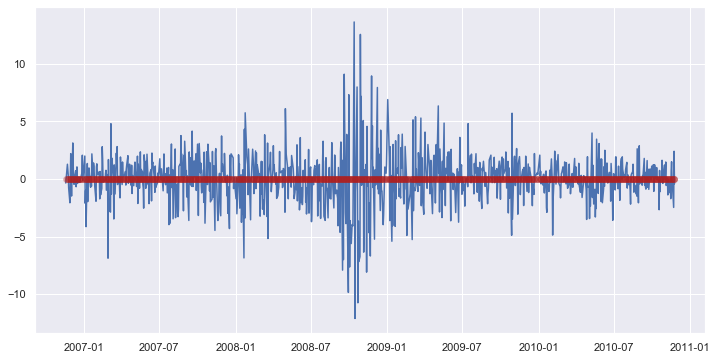

In [56]:
# OBS: se der tempo, transformar para y em nível e fazer mesmo gráfico com a volatilidade
plt.figure(figsize=(12,6))
plt.plot(y.index,y);
plt.plot(y.index,h[2]*10, 'ob', alpha=0.2, color='firebrick');

**Cadeias de $\phi$, $\sigma^2_{\eta}$ e $\beta$**

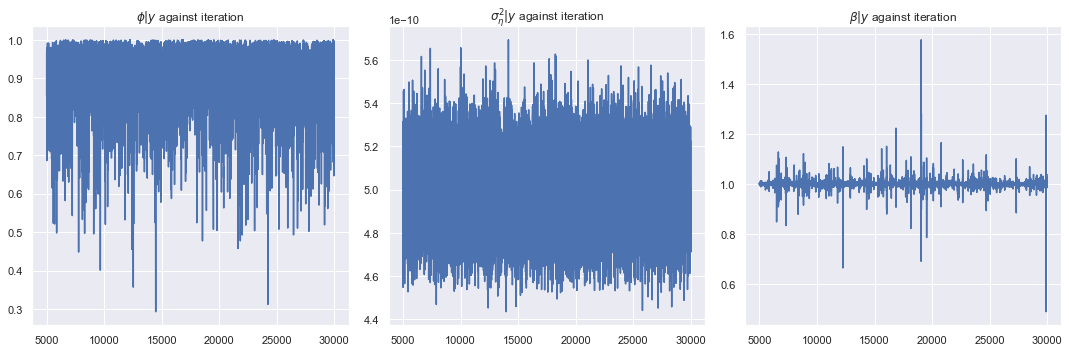

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
sns.lineplot(x=list(range(burnin,N)),y=phi2, ax = ax[0])
sns.lineplot(x=list(range(burnin,N)),y=s2_n2*1e-5, ax = ax[1])
sns.lineplot(x=list(range(burnin,N)),y=beta2, ax = ax[2])

ax[0].set_title(r'$\phi|y$ against iteration');
ax[1].set_title(r'$\sigma^2_{\eta}|y$ against iteration');
ax[2].set_title(r'$\beta|y$ against iteration');

plt.tight_layout()
# plt.savefig('algo_base_chains.png')

**Distribuições de $\phi$, $\sigma^2_{\eta}$ e $\beta$**

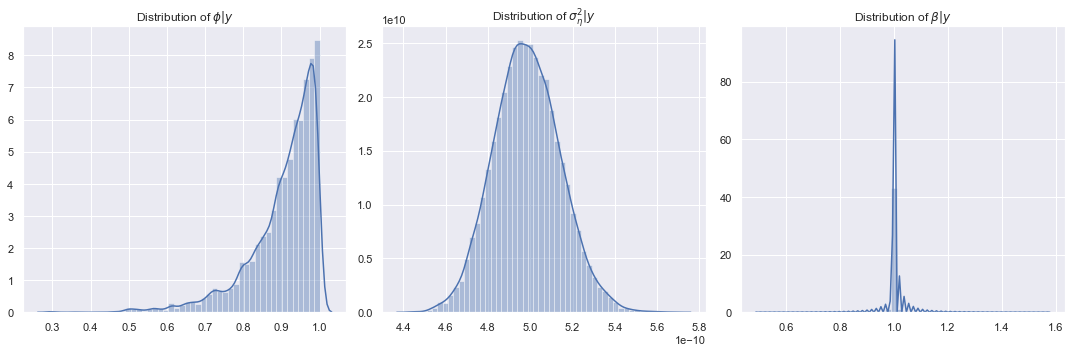

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5));
sns.distplot(phi2, ax = ax[0], norm_hist= True);
sns.distplot(s2_n2*1e-5, ax = ax[1], norm_hist= True);
sns.distplot(beta2, ax = ax[2], norm_hist= True);

ax[0].set_title(r'Distribution of $\phi|y$');
ax[1].set_title(r'Distribution of $\sigma^2_{\eta}|y$');
ax[2].set_title(r'Distribution of $\beta|y$');

plt.tight_layout()
# plt.savefig('algo_base_dist.png')

**Autocorrelação de $\phi$, $\sigma^2_{\eta}$ e $\beta$**

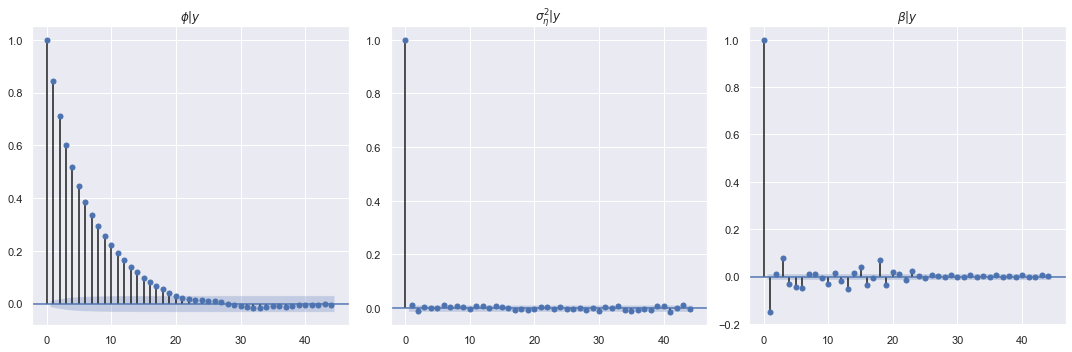

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
plot_acf(phi2, ax = ax[0], title=r'$\phi | y$');
plot_acf(s2_n2, ax = ax[1], title=r'$\sigma^2_{\eta} | y$');
plot_acf(beta2, ax = ax[2], title=r'$\beta | y$');

plt.tight_layout()
# plt.savefig('algo_base_autocorr.png')

In [50]:
# pd.DataFrame(h).to_csv('algo_base_h.csv')
# pd.DataFrame([phi, mu, s2_n, beta], index=['phi', 'mu', 's2_n', 'beta']).transpose().to_csv('algo_base_params.csv')